# Demonstrate perspective transform

- import libs
- Set parameters including image, Field Of View and rotation vector

To run the jupyter-notebook from inside a virtualenv, see:
- http://help.pythonanywhere.com/pages/IPythonNotebookVirtualenvs
- https://ipython.readthedocs.io/en/latest/install/kernel_install.html

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from __future__ import division

IMAGE="files/ps-doom.jpg"
FOV=30
ROT_VEC = np.deg2rad([45,0,0])

- Compute the image center
- Distance from the camera given the field of view
- Prepare selection indices to select on 3×3 matrix from 4×4 matrix

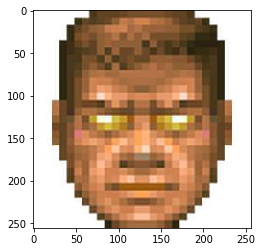

In [2]:
img = mpimg.imread(IMAGE)
plt.imshow(img)
img_center = [side // 2 for side in img.shape[:2]]
distance = (img.shape[0] // 2) / np.tan(np.deg2rad(FOV // 2))

rot_vec = ROT_VEC
cos_rot_vec = np.cos(rot_vec)
sin_rot_vec = np.sin(rot_vec)

rows_id = np.asarray([0, 1, 3])
rows_id = rows_id[:, np.newaxis]

Translate the image into origin of world coordinate system. ($z$ is already $0$)

[[   1.    0.    0. -128.]
 [   0.    1.    0. -128.]
 [   0.    0.    1.    0.]
 [   0.    0.    0.    1.]]


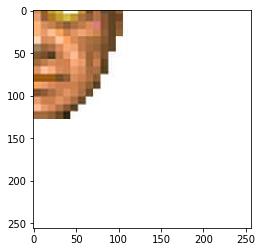

In [3]:
identity = np.identity(4).reshape(4, 4)
translate = np.asarray([[1, 0, 0, -img_center[1]],
                        [0, 1, 0, -img_center[0]],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

p0 = translate.dot(identity)
print(p0)
fin = p0[rows_id, [0, 1, 3]]

warped_image = cv2.warpPerspective(img, fin,
                                   (img.shape[1], img.shape[0]),
                                   borderMode=cv2.BORDER_CONSTANT,
                                   flags=cv2.INTER_LANCZOS4,
                                   borderValue=(255, 255, 255))
plt.imshow(warped_image)
              

Rotate the image given axis angles $[x, y , z]$.

[[   1.            0.            0.         -128.        ]
 [   0.            0.70710678   -0.70710678  -90.50966799]
 [   0.            0.70710678    0.70710678  -90.50966799]
 [   0.            0.            0.            1.        ]]


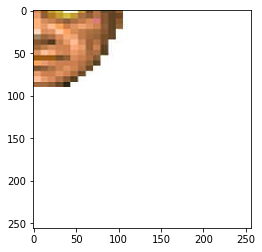

In [4]:
rot_x = np.asarray([[1, 0, 0, 0],
                    [0, cos_rot_vec[0], -sin_rot_vec[0], 0],
                    [0, sin_rot_vec[0], cos_rot_vec[0], 0],
                    [0, 0, 0, 1]])

rot_y = np.asarray([[cos_rot_vec[1], 0, sin_rot_vec[1], 0],
                    [0, 1, 0, 0],
                    [-sin_rot_vec[1], 0, cos_rot_vec[1], 0],
                    [0, 0, 0, 1]])

rot_z = np.asarray([[cos_rot_vec[2], -sin_rot_vec[2], 0, 0],
                    [sin_rot_vec[2], cos_rot_vec[2], 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

p1 = rot_z.dot(rot_y.dot(rot_x.dot(p0)))
print(p1)
fin = p1[rows_id, [0, 1, 3]]
warped_image = cv2.warpPerspective(img, fin, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_CONSTANT,
                                   flags=cv2.INTER_LANCZOS4, borderValue=(255, 255, 255))
plt.imshow(warped_image)

Translate the image into projection plane along the $z$ by distance.

[[   1.            0.            0.         -128.        ]
 [   0.            0.70710678   -0.70710678  -90.50966799]
 [   0.            0.70710678    0.70710678  387.19283538]
 [   0.            0.            0.            1.        ]]


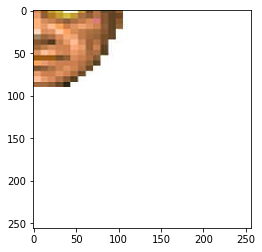

In [5]:
translate_from_camera = np.asarray([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, distance],
                             [0, 0, 0, 1]])
p2 = translate_from_camera.dot(p1)
print(p2)
fin = p2[rows_id, [0, 1, 3]]

warped_image = cv2.warpPerspective(img, fin, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_CONSTANT,
                                   flags=cv2.INTER_LANCZOS4, borderValue=(255, 255, 255))
plt.imshow(warped_image)

Apply projection matrix and select its 3×3 subspace. https://msdn.microsoft.com/en-us/library/windows/desktop/bb153309(v=vs.85).aspx

[[  1.00000000e+00   0.00000000e+00   0.00000000e+00  -1.28000000e+02]
 [  0.00000000e+00   7.07106781e-01  -7.07106781e-01  -9.05096680e+01]
 [  0.00000000e+00   7.07106781e-01   7.07106781e-01  -9.05096680e+01]
 [  0.00000000e+00   1.48022415e-03   1.48022415e-03   8.10531309e-01]]


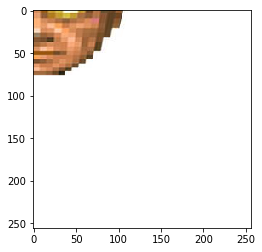

In [6]:
camera = np.asarray([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, -distance],
                     [0, 0, 1/distance, 0]])
p3 = camera.dot(p2)
print(p3)
rows_id = np.asarray([0, 1, 3])
rows_id = rows_id[:, np.newaxis]

p4 = p3[rows_id, [0, 1, 3]]
warped_image = cv2.warpPerspective(img, p4, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_CONSTANT,
                                   flags=cv2.INTER_LANCZOS4, borderValue=(255, 255, 255))
plt.imshow(warped_image)

Finally, translate the image such that its left up corner is in the origin.

[[  1.00000000e+00   1.89468691e-01  -2.42519924e+01]
 [  0.00000000e+00   8.96575472e-01   1.32383396e+01]
 [  0.00000000e+00   1.48022415e-03   8.10531309e-01]]


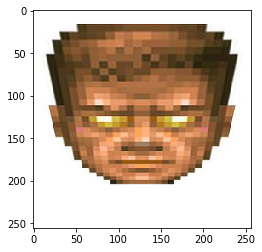

In [7]:
align = np.asarray([[1, 0, img_center[1]],
                    [0, 1, img_center[0]],
                    [0, 0, 1]])
fin = align.dot(p4)
#fin[2,2]=1.
print (fin)

warped_image = cv2.warpPerspective(img, fin, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_CONSTANT,
                                   flags=cv2.INTER_LANCZOS4, borderValue=(255, 255, 255))
plt.imshow(warped_image)